In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda, Layer

In [4]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES']="1"

#physical_devices = tf.config.list_physical_devices('GPU') 
#tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
#tf.shape(hidden_layer_1M)

In [50]:
class MyDenseLayer(Layer):

    def __init__(self, kernel_initilizer=tf.keras.initializers.Ones(), num_outputs=50, **kwargs):
        super(MyDenseLayer, self).__init__(**kwargs)
        self.kernel_initializer = tf.keras.initializers.get(kernel_initilizer)
        self.num_outputs = num_outputs

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self._b = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
        self._c = self.add_weight(name='x', 
                                    shape=[int(input_shape[-1]),
                                         self.num_outputs],
                                    initializer=self.kernel_initializer, #'uniform',
                                    trainable=True)
        self._d = self.add_weight(name='x', 
                                    shape=[
                                         self.num_outputs],
                                    initializer=tf.keras.initializers.Zeros(), #'uniform',
                                    trainable=True)

        super(MyDenseLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return tf.matmul(tf.nn.relu(x), self._b) - tf.matmul(tf.nn.relu(-x), self._c) + self._d

In [57]:
#Define the discriminator
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
Discriminator = Model(inputs=inputs, outputs=outputs)
Discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#Define the mapping function:
inputsM = Input((2, ))

initializer = tf.keras.initializers.Identity()

hidden_layer_1M = MyDenseLayer()(inputsM)
#hidden_layer_2M = MyDenseLayer()(hidden_layer_1M)
hidden_layer_3M = Dense(2, activation='linear', kernel_initializer=initializer)(hidden_layer_1M)
MappingFunc = Model(inputs=inputsM, outputs=hidden_layer_3M)

#Define the generator
inputsG = Input((3, ))
concatenate_layerG = Concatenate()([MappingFunc(inputsG[:,1:3]),inputsG[:,0:1]])
outputG = concatenate_layerG[:, 1]+concatenate_layerG[:, 0]*concatenate_layerG[:, 2]
Generator = Model(inputs=inputsG, outputs=outputG)

#Define the full GAN for training
inputsGAN = Input((3, ))
GAN = Model(inputs=inputsGAN,outputs=Discriminator(Generator(inputsGAN)))
GAN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [58]:
# generate n real samples with class labels
def generate_real_samples(n):
    rng = np.random.default_rng()
    x = rng.normal(0,1,n)
    y = np.ones((n, 1))
    batches = [.5]*(n//4) + [1]*(n//4) + [-0.5]*(n//4) + [-1]*(n//4)
    b = batches #np.ones(n) #(np.random.rand(n)*10)-5
    c = batches #np.ones(n) #(np.random.rand(n)*10)-5
    X = np.c_[x,b,c]
    rng.shuffle(X)
    return X, y

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(real_samples,generator, n):
    # predict outputs
    X = np.c_[Generator.predict(real_samples),real_samples[:,1],real_samples[:,2]]
    # create class labels
    y = np.zeros((n, 1))
    return X, y

In [32]:
m = 200
n_batch = m
n_epochs = 5*m
half_batch = int(n_batch / 2)
# manually enumerate epochs
for i in range(n_epochs):
    # prepare real samples
    x_real, y_real = generate_real_samples(half_batch)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(x_real, Generator, half_batch)
    Discriminator.train_on_batch(x_real[:,0], y_real)
    Discriminator.train_on_batch(x_fake[:,0], y_fake)
    Discriminator.trainable = False
    # update the generator via the discriminator's error
    loss = GAN.train_on_batch(x_real, np.ones(len(x_real)), return_dict=True)
    Discriminator.trainable = True
    #Discriminator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    if(i%m == 0):
        print(i,MappingFunc.predict([[1,1]]))
        print(loss)

0 [[ 0.12872952 -0.1561209 ]]
{'loss': 0.3378937542438507, 'accuracy': 1.0}
200 [[-0.16252278 -1.339544  ]]
{'loss': 0.46098172664642334, 'accuracy': 0.8600000143051147}
400 [[-0.06054169 -0.49958602]]
{'loss': 0.25768986344337463, 'accuracy': 1.0}
600 [[-0.4550407 -0.5344673]]
{'loss': 0.28453540802001953, 'accuracy': 1.0}
800 [[-0.52948874 -0.43712825]]
{'loss': 0.2505776882171631, 'accuracy': 1.0}


In [21]:
Generator.predict([[3,-1, -1]])

array([0.03420836], dtype=float32)

In [22]:
MappingFunc.predict([[2,3]])

array([[-1.0018297,  2.9840097]], dtype=float32)

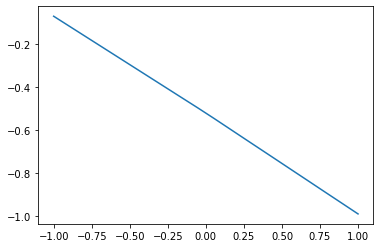

In [33]:
preds = Generator.predict([[1,1,x] for x in np.linspace(-1,1,20)])
plt.plot(np.linspace(-1,1,20),preds)

In [59]:
b_i = []
b_f = []
c_i = []
c_f = []


for j in np.linspace(-1.5, 1.5):
    preds = MappingFunc.predict([[j,j]])
    b_i.append(j)
    c_i.append(j)
    c_f.append(preds[0,1])
    b_f.append(preds[0, 0])
    
        

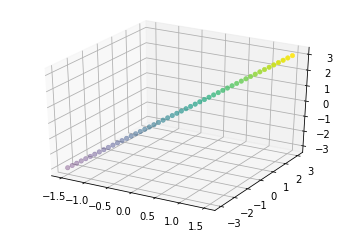

In [60]:
ax = plt.axes(projection='3d')
ax.scatter(c_i, c_f, b_f,
                c=b_f, cmap='viridis', linewidth=0.5)

Text(0, 0.5, 'final slope')

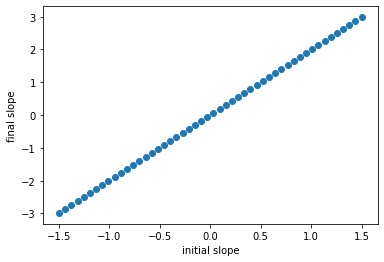

In [61]:
plt.scatter(c_i, c_f)
plt.xlabel("initial slope")
plt.ylabel("final slope")

Text(0, 0.5, 'final intercept')

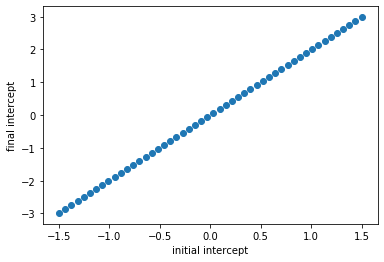

In [62]:
plt.scatter(b_i, b_f)
plt.xlabel("initial intercept")
plt.ylabel("final intercept")

In [19]:
x_real, y_real = generate_real_samples(10000)
x_fake, y_fake = generate_fake_samples(x_real, Generator, 10000)

(array([ 300.,  514., 1031., 1613., 2057., 1874., 1164.,  559.,  304.]),
 array([-2.        , -1.55555556, -1.11111111, -0.66666667, -0.22222222,
         0.22222222,  0.66666667,  1.11111111,  1.55555556,  2.        ]),
 <a list of 9 Patch objects>)

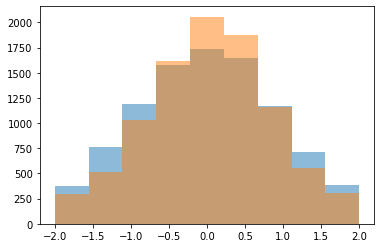

In [24]:
plt.hist(x_real[:,0],bins=np.linspace(-2,2,10),alpha=0.5)
plt.hist(x_fake[:,0],bins=np.linspace(-2,2,10),alpha=0.5)

In [49]:
np.mean(x_real[:,0])

-0.009328091088893257

In [50]:
np.mean(x_fake[:,0])

0.5524935805901885

In [1]:
plt.scatter(x_real[:,0],x_fake[:,0])

NameError: name 'plt' is not defined

In [3]:
inputsM = Input((2, ))
initializer = tf.keras.initializers.Identity()
hidden_layer_1M = Dense(50, activation='relu', kernel_initializer=initializer)(inputsM)
hidden_layer_2M = Dense(50, activation='relu', kernel_initializer=initializer)(hidden_layer_1M)
hidden_layer_3M = Dense(2, activation='linear', kernel_initializer=initializer)(hidden_layer_2M)
MappingFunc = Model(inputs=inputsM, outputs=hidden_layer_3M)
#GAN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [7]:
MappingFunc.predict([[-7, -2]])

array([[0., 0.]], dtype=float32)

In [38]:
np.shape(preds)

(1, 2)

In [43]:
MappingFunc.predict([[1, 1]])

array([[9.389137e-05, 6.659047e-01]], dtype=float32)